Background Information
The Big Five personality traits, also known as the five-factor model (FFM) and the OCEAN model, is a taxonomy, or grouping, for personality traits. When factor analysis (a statistical technique) is applied to personality survey data, some words used to describe aspects of personality are often applied to the same person. For example, someone described as conscientious is more likely to be described as "always prepared" rather than "messy". This theory is based therefore on the association between words but not on neuropsychological experiments. This theory uses descriptors of common language and therefore suggests five broad dimensions commonly used to describe the human personality and psyche.

The Dataset
This dataset contains 1,015,342 questionnaire answers collected online by Open Psychometrics.

Notebook
This notebook seeks to develop a machine learning application to define and classify personality clusters. The database has more than 1 million records, in which some patterns in the answers can be identified. These patterns are analyzed and identified as clusters. Finally, an interface was built that receives user responses according to the personality trait question and then classifies it in some cluster of the model.

https://www.kaggle.com/datasets/tunguz/big-five-personality-test

In [1]:
#Importing modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import open
pd.options.display.max_columns = 150


In [2]:
#Loading dataset

#Obs.: This dataset are using TAB for separation values, then we use sep='\t'.

data = pd.read_csv('data-final.csv', sep='\t')

#Deleting all columns that we will not use (responding time, country, etc)

data.drop(data.columns[50:110], axis=1, inplace=True)


In [3]:
#Analising statistics in dataset

#Setting values to float
pd.options.display.float_format = "{:.2f}".format

#Show the statistics analysis
data.describe()

#Obs.: Was identified answers with 0 as value. Althrough the minimal is 1.
#Must need to repair this divergence

data["EXT1"].value_counts()

3.00    288622
1.00    249711
2.00    199165
4.00    191638
5.00     80702
0.00      3720
Name: EXT1, dtype: int64

In [4]:
#Select all data with value equal zero

data[(data==0.00).all(axis=1)].describe()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
count,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00,2094.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [6]:
#Cleaning all the data equal zero
data = data[(data>0.00).all(axis=1)]
data["EXT1"].value_counts()

3.00    247835
1.00    216949
2.00    176207
4.00    166599
5.00     66844
Name: EXT1, dtype: int64

In [7]:
#Search the amount of clusters

#Importing modules
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

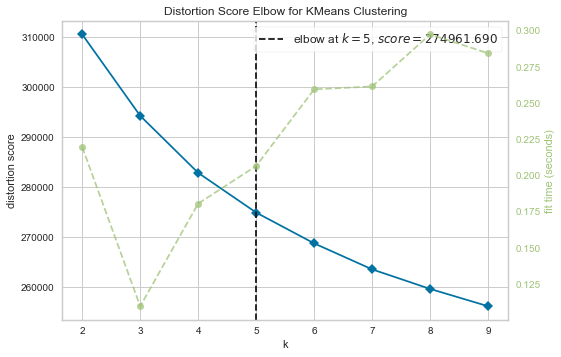

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
#Setting KMeans and Visualizar
kmeans = KMeans()

#Setting k = 2 for kmeans (testing groups)
visualizer = KElbowVisualizer(kmeans,k=(2,10))

#Setting sample to 5000 items
data_sample = data.sample(n=5000, random_state = 1)

#Testing
visualizer.fit(data_sample)
visualizer.poof()

#Result: The KMeans Distortion Score indicates k=5

In [9]:
#Grouping the data in 5 clusters
kmeans = KMeans(n_clusters = 5)
k_fit = kmeans.fit(data)

In [10]:
#Naming the clusters
pred = k_fit.labels_
data['Clusters'] = pred

#Checking
data.head()

#data['Clusters'].value_counts()

#Ok, now we can identify a answer by his cluster!

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,Clusters
0,4.00,1.00,5.00,2.00,5.00,1.00,5.00,2.00,4.00,1.00,1.00,4.00,4.00,2.00,2.00,2.00,2.00,2.00,3.00,2.00,2.00,5.00,2.00,4.00,2.00,3.00,2.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,2.00,4.00,4.00,2.00,4.00,4.00,5.00,1.00,4.00,1.00,4.00,1.00,5.00,3.00,4.00,5.00,0
1,3.00,5.00,3.00,4.00,3.00,3.00,2.00,5.00,1.00,5.00,2.00,3.00,4.00,1.00,3.00,1.00,2.00,1.00,3.00,1.00,1.00,4.00,1.00,5.00,1.00,5.00,3.00,4.00,5.00,3.00,3.00,2.00,5.00,3.00,3.00,1.00,3.00,3.00,5.00,3.00,1.00,2.00,4.00,2.00,3.00,1.00,4.00,2.00,5.00,3.00,4
2,2.00,3.00,4.00,4.00,3.00,2.00,1.00,3.00,2.00,5.00,4.00,4.00,4.00,2.00,2.00,2.00,2.00,2.00,1.00,3.00,1.00,4.00,1.00,4.00,2.00,4.00,1.00,4.00,4.00,3.00,4.00,2.00,2.00,2.00,3.00,3.00,4.00,2.00,4.00,2.00,5.00,1.00,2.00,1.00,4.00,2.00,5.00,3.00,4.00,4.00,4
3,2.00,2.00,2.00,3.00,4.00,2.00,2.00,4.00,1.00,4.00,3.00,3.00,3.00,2.00,3.00,2.00,2.00,2.00,4.00,3.00,2.00,4.00,3.00,4.00,2.00,4.00,2.00,4.00,3.00,4.00,2.00,4.00,4.00,4.00,1.00,2.00,2.00,3.00,1.00,4.00,4.00,2.00,5.00,2.00,3.00,1.00,4.00,4.00,3.00,3.00,2
4,3.00,3.00,3.00,3.00,5.00,3.00,3.00,5.00,3.00,4.00,1.00,5.00,5.00,3.00,1.00,1.00,1.00,1.00,3.00,2.00,1.00,5.00,1.00,5.00,1.00,3.00,1.00,5.00,5.00,3.00,5.00,1.00,5.00,1.00,3.00,1.00,5.00,1.00,5.00,5.00,5.00,1.00,5.00,1.00,5.00,1.00,5.00,3.00,5.00,5.00,0


In [11]:
#But if i need to identify the means of a cluster, what can i must to do?
#First i need to group data by clusters and get the mean
#Second i need to group the columns by the type of answer and get the mean (total/10)

#Grouping by clusters and mean
data.groupby('Clusters').mean()

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
Clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.46,1.96,4.33,2.24,4.26,1.68,3.87,2.82,3.74,2.53,2.32,3.85,3.14,3.32,2.11,1.90,2.10,1.67,2.11,1.71,1.89,4.44,1.84,4.25,1.87,3.86,1.60,4.10,4.09,4.20,3.75,2.58,4.20,1.89,3.14,2.27,3.88,1.94,3.59,3.89,3.91,1.75,4.09,1.79,4.16,1.66,4.33,3.25,4.11,4.29
1,1.81,3.63,2.23,4.06,2.30,3.18,1.75,4.08,2.18,4.48,4.29,2.46,4.52,2.13,3.57,3.90,4.01,3.78,4.01,3.96,2.46,3.38,2.59,3.85,2.56,3.87,2.71,3.44,3.68,3.06,2.81,3.39,3.81,3.51,2.07,3.52,3.56,3.06,2.76,3.31,3.52,2.38,4.08,2.12,3.43,2.09,3.69,3.19,4.29,3.73
2,2.15,3.45,2.81,3.59,2.61,2.87,2.12,3.72,2.69,4.00,2.43,3.73,3.13,3.00,2.39,2.09,2.39,1.99,2.68,2.37,3.07,3.01,2.64,2.89,3.25,2.77,3.12,2.97,2.71,3.09,3.29,2.91,3.83,2.47,2.44,2.81,3.55,2.58,2.89,3.52,3.73,1.96,3.79,2.05,3.79,2.05,4.09,3.30,3.92,3.84
3,3.46,1.91,3.81,2.49,4.07,1.81,3.67,2.75,3.79,2.99,3.81,2.96,4.24,2.43,3.27,3.47,3.80,3.44,3.64,3.17,2.14,4.30,2.66,4.19,2.00,4.01,1.85,3.91,4.13,3.86,2.98,3.63,3.85,3.25,2.22,3.54,3.46,2.84,2.94,3.49,3.79,2.10,4.27,1.95,3.98,1.76,4.00,3.40,4.21,4.21
4,2.14,3.27,3.11,3.64,3.00,2.69,2.23,3.99,2.33,4.12,3.58,3.05,4.19,2.60,2.86,2.87,2.92,2.49,3.02,2.74,1.85,3.98,1.68,4.39,1.96,4.19,1.99,4.01,4.20,3.73,3.86,2.21,4.30,2.03,3.25,2.06,4.18,2.02,3.86,3.90,3.56,2.17,3.88,2.08,3.71,2.00,4.00,2.96,4.26,3.79


In [12]:
#Setting columns of each group
col_list = list(data)
EXT = col_list[0:10]
EST = col_list[10:20]
AGR = col_list[20:30]
CSN = col_list[30:40]
OPN = col_list[40:50]

#Sum columns with the same type of personality and extract the mean
data_sum = pd.DataFrame()
data_sum['EXTROVERSION'] = data[EXT].sum(axis=1)/10
data_sum['NEUROTIC'] = data[EST].sum(axis=1)/10
data_sum['AGREEABLE'] = data[AGR].sum(axis=1)/10
data_sum['CONSCIENTIOUS'] = data[CSN].sum(axis=1)/10
data_sum['OPEN'] = data[OPN].sum(axis=1)/10
data_sum['clusters'] = pred

#Grouping the dataframe by clusters
data_sum.groupby('clusters').mean()

data_clusters = data_sum.groupby('clusters').mean()

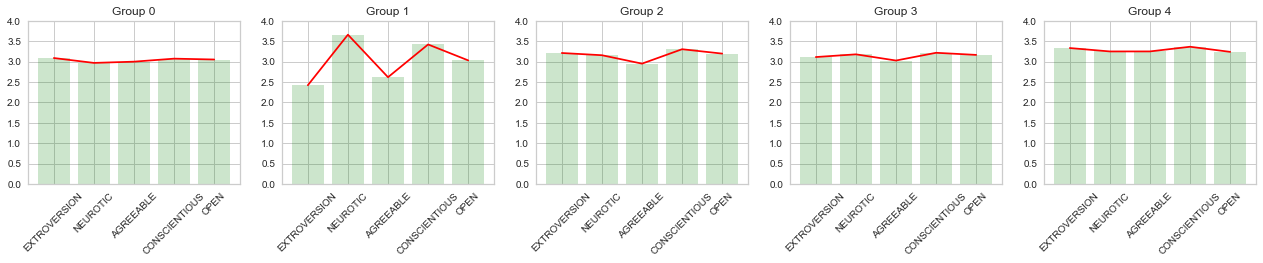

In [13]:
#Ploting the means by group in a graph plot figure

plt.figure(figsize=(22,3))
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.bar(data_clusters.columns, data_clusters.iloc[:,i], color='green', alpha=0.2)
    plt.plot(data_clusters.columns,data_clusters.iloc[:,i], color='red')
    plt.title('Group '+ str(i))
    plt.xticks(rotation=45)
    plt.ylim(0,4);


In [19]:
#Now we need to develop a interface to interact with the user
#The interface will get data to predict the user's cluster

import gradio as gr

In [20]:
#Reading survey's questions
#The questions are splitted by ENTER command, so we use split("\n")
d_questions = open("questions.txt").read().split("\n")
d_questions

['EXT1\tI am the life of the party.',
 "EXT2\tI don't talk a lot.",
 'EXT3\tI feel comfortable around people.',
 'EXT4\tI keep in the background.',
 'EXT5\tI start conversations.',
 'EXT6\tI have little to say.',
 'EXT7\tI talk to a lot of different people at parties.',
 "EXT8\tI don't like to draw attention to myself.",
 "EXT9\tI don't mind being the center of attention.",
 'EXT10\tI am quiet around strangers.',
 'EST1\tI get stressed out easily.',
 'EST2\tI am relaxed most of the time.',
 'EST3\tI worry about things.',
 'EST4\tI seldom feel blue.',
 'EST5\tI am easily disturbed.',
 'EST6\tI get upset easily.',
 'EST7\tI change my mood a lot.',
 'EST8\tI have frequent mood swings.',
 'EST9\tI get irritated easily.',
 'EST10\tI often feel blue.',
 'AGR1\tI feel little concern for others.',
 'AGR2\tI am interested in people.',
 'AGR3\tI insult people.',
 "AGR4\tI sympathize with others' feelings.",
 "AGR5\tI am not interested in other people's problems.",
 'AGR6\tI have a soft heart.',


In [24]:
#Obtaining only the questions
questions = []
for q in d_questions:
    q = str(q)
    #get all sentence after \t command and lstrip to remove blank spaces
    questions.append(q[q.find("\t"):].lstrip())
questions

['I am the life of the party.',
 "I don't talk a lot.",
 'I feel comfortable around people.',
 'I keep in the background.',
 'I start conversations.',
 'I have little to say.',
 'I talk to a lot of different people at parties.',
 "I don't like to draw attention to myself.",
 "I don't mind being the center of attention.",
 'I am quiet around strangers.',
 'I get stressed out easily.',
 'I am relaxed most of the time.',
 'I worry about things.',
 'I seldom feel blue.',
 'I am easily disturbed.',
 'I get upset easily.',
 'I change my mood a lot.',
 'I have frequent mood swings.',
 'I get irritated easily.',
 'I often feel blue.',
 'I feel little concern for others.',
 'I am interested in people.',
 'I insult people.',
 "I sympathize with others' feelings.",
 "I am not interested in other people's problems.",
 'I have a soft heart.',
 'I am not really interested in others.',
 'I take time out for others.',
 "I feel others' emotions.",
 'I make people feel at ease.',
 'I am always prepared.

In [25]:
#Create a list that receives data by the user
inputs_questions = []
for q in questions:
    obj_input = gr.inputs.Slider(minimum = 1, maximum = 5, step = 1,default = 3, label=q)
    inputs_questions.append(obj_input)

In [27]:
#Create a interface with gradio
def predict(*outputs_questions):
    outputs_questions = np.array(outputs_questions).reshape(1,-1)
    return k_fit.predict(outputs_questions)

iface = gr.Interface(
                    fn = predict,
                    title = "Big Five Personality",
                    description = "Personality Traits Detection System. The scale was labeled 1=Disagree, 3=Neutral, 5=Agree.",
                    inputs = inputs_questions,
                    outputs = "text")
iface.launch(share=True)

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://500e0e05-5036-45c9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
